# Tâche 9 : ph_dos

- Téléchargez la densité d'états de phonons du matériau attribué
- Calculez les températures de Debye $θ_D$ et d'Einstein $θ_E$ telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique
- Représentez les trois courbes de chaleur spécifique (celle correspondant au matériau ainsi que celles obtenues à partir des 2 modèles)
- Représentez les trois densités d'états de phonons correspondantes

## 1. Densité d'état (DOS) de phonons du ZrCoBi

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from lmapr1492 import get_plot_bs, get_plot_dos, get_plot_bs_and_dos
from scipy.optimize import minimize
from scipy.integrate import quad

mp_key = "XmhOs3iaP3YopOzhwHSd0LHcduZB1r1h"
mp_id = "mp-31451"
material_name = "ZrCoBi"


# Récupération de la structure et de la DOS de phonons
with MPRester(mp_key) as m:
    structure = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

# Représentation de la DOS
fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.show()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Calcul des températures de Debye $θ_D$ et d'Einstein $θ_E$ 

Le modèle de **Debye** fait l'hypothèse que les fréquences $\omega_\sigma (q)$ ont la **même dispersion linéaire**: $\omega_\sigma (q) = vq$ (avec $v$ la vitesse de phase). Il suppose aussi que l'intégrale se fait sur une **sphère de rayon $q_D$** (de telle sorte que la sphère contienne $N_{\text{cell}}$ vecteurs d'ondes $q$ permis) et non sur la zone de Brillouin. 

La température de Debye est définie comme : $\theta_D = \frac{ℏvq_D}{k_B} [K]$

En effectuant le changement de variable $ x = \frac{ℏvq}{k_BT}$ on trouve : $\frac{C_v}{3 N_{\text{at}} R} = 3 \left( \frac{\theta_D}{T} \right)^3 \int_{0}^{\frac{\theta_D}{T}} \frac{x^4 e^x}{(e^x - 1)^2} dx$   

Le modèle d'**Einstein**, quant à lui, fait l'hypothèse que les fréquences $\omega_\sigma (q)$ sont égales à une **fréquence naturelle de vibration $\omega_E$** . En effet, on néglige l'interaction entre atomes.

La température d'Einstein est définie comme : $\theta_E = \frac{ℏ\omega_E}{k_B} [K]$

On trouve : $\frac{C_v}{3 N_{\text{at}} R} = \left( \frac{ \theta_E }{T} \right)^2 \frac{ e^{\frac{\theta_E}{T}} }{ \left( e^{\frac{\theta_E}{T}} - 1 \right)^2 }$

In [15]:
N_at = len(structure) # Nombre d'atome dans la cellule unité
R = 8.314
exp_T = np.array(np.arange(5, 1000, 5))
Cv = np.array([ph_dos.cv(exp_T[i])/ (3*N_at*R) for i in range(len(exp_T))])

# Cv de Debye
# Intégrande Debye
def integrand(x):
    return x**4 * np.exp(x) / (np.exp(x) - 1)**2

def Debye(T, theta_D):
    return 3 * ((T/theta_D)**3) * quad(integrand, 0, theta_D/T)[0]  # Calcul de l'intégrande de 0 à theta_D/T

def error_Debye(theta_D):
    return np.sum([(Debye(exp_T[i], theta_D) - Cv[i])**2 for i in range(len(exp_T))])
 
theta_D_init = 250
theta_D_optimal = minimize(error_Debye, theta_D_init).x[0]

print("\nLa température de Debye vaut   : ",theta_D_optimal," [K]")


# Cv d'Einstein
def Einstein(T, theta_E):
    exp = np.exp(theta_E/T)
    return (theta_E/T)**2 * (exp/(exp-1)**2)

def error_Einstein(theta_E):
    Cv_E = Einstein(exp_T, theta_E)  
    return np.sum((Cv - Cv_E)**2)

theta_E_init = 250
theta_E_optimal = minimize(error_Einstein, theta_E_init).x[0]

print("La température d'Einstein vaut : ",theta_E_optimal,"[K]")


La température de Debye vaut   :  311.3543000538191  [K]
La température d'Einstein vaut :  230.35161072347157 [K]


## 3. Courbes de chaleur spécifique

La **chaleur spécifique** est la capacité d'un matériau à accumuler de l'énergie sous forme thermique lorsque la température augmente. On voit sur le graphe que cette capacité augmente avec la température jusqu'à stagner au alentours de **400[K]**.

Dans un solide cristallin, la chaleur spécifique est associée aux **vibrations** des atomes autour de leur position d'équilibre, c'est à dire les **phonons**. En effet, les phonons transportent l'énergie thermique par le biais de leur vibration.

Le modèle de Debye émet des hypothèses plus **réalistes** que celui d'Einstein. On voit bien sur ce graphe que, à **basse température**, le modèle de Debye est effectivement plus proche des valeurs expérimentales. Le modèle de Debye prédit une **évolution de $C_v$ en $T^3$** à basse température.

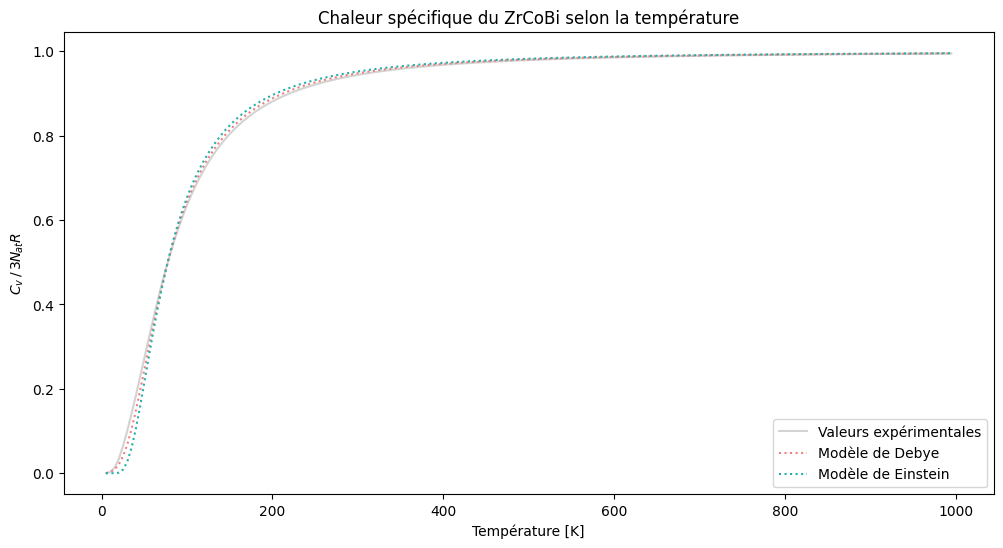

In [17]:
Cv_E = Einstein(exp_T, theta_E_optimal)
Cv_D = np.array([Debye(T, theta_D_optimal) for T in exp_T])

plt.figure(figsize=(12, 6))
plt.plot(exp_T, Cv, label="Valeurs expérimentales", color='lightgray')
plt.plot(exp_T, Cv_D, label="Modèle de Debye", linestyle='dotted', color='lightcoral')
plt.plot(exp_T, Cv_E, label="Modèle de Einstein" , linestyle='dotted', color='lightseagreen')
plt.xlabel('Température [K]')
plt.ylabel("$C_v\,/\,3N_{\!at}R$")
plt.title("Chaleur spécifique du ZrCoBi selon la température")
plt.legend()
plt.show()

## 4. Représentation des trois densités d'états de phonons correspondantes

La **densité d'états** (DOS) est une fonction qui quantifie le nombre d'états électroniques qui peuvent être occupés pour une certaine énergie. Elle quantifie aussi le nombre de **modes de vibrations** accessibles pour une fréquence donnée pour les phonons. La densité d'état totale pour un matériau vaut **$3N_{\text{at}}$** et est égale à l'**air sous la courbe**. En effet, un atome a 3 directions de vibration.

Comme expliqué au point 2, une seule fréquence est considérée dans le modèle d'**Einstein**. Dès lors, toutes les DOS sont données à la même fréquence : $\omega_E$. On a bien une aire sous la courbe qui vaut $3N_{\text{at}}$.

La courbe illustrant la DOS du modèle de **Debye** est parabolique jusqu'à $\theta_D$ où elle chute à 0 afin de garantir que l'air sous la courbe vaut $3N_{\text{at}}$.



La fréquence de Debye vaut                                         :  311.3543000538191  [THz]
La fréquence d'Einstein (ou fréquence naturelle de vibration) vaut :  230.35161072347157 [THz]
-------------------------------------------------------------------------------------------------------------------


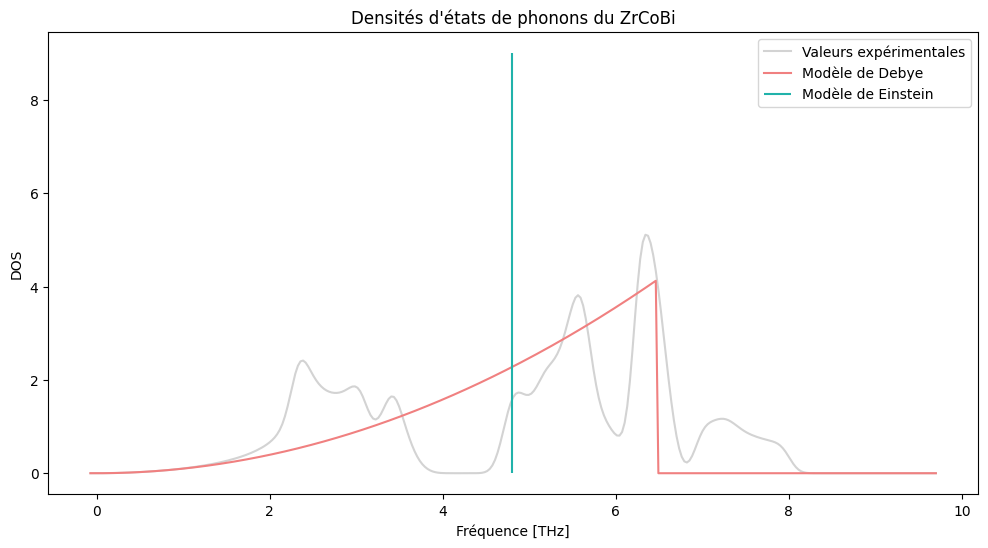

In [18]:
k_B = 1.380649e-23
hbar = 1.054e-34  
toTHz = 1e-12     

freq = ph_dos.frequencies 
dens = ph_dos.densities

omega_E = toTHz * (theta_E_optimal * k_B)/hbar
omega_D = toTHz * (theta_D_optimal * k_B)/hbar

print("\nLa fréquence de Debye vaut                                         : ",theta_D_optimal," [THz]")
print("La fréquence d'Einstein (ou fréquence naturelle de vibration) vaut : ",theta_E_optimal,"[THz]")
print("-------------------------------------------------------------------------------------------------------------------")
    
dens_D = np.zeros(len(freq))
for i,f in enumerate(freq):
    omega = 2*np.pi*f
    if omega < omega_D:
        dens_D[i] = (9*N_at*(omega)**2/(omega_D**3))

plt.figure(figsize=(12, 6))
plt.plot(freq, dens, color='lightgray', label="Valeurs expérimentales")
plt.plot(freq, dens_D*2*np.pi, color='lightcoral', label="Modèle de Debye")
plt.vlines(omega_E/(2*np.pi), 0, 3*N_at, colors="lightseagreen", label="Modèle de Einstein")
plt.ylabel("DOS")
plt.xlabel("Fréquence [THz]")
plt.title("Densités d'états de phonons du ZrCoBi")
plt.legend()
plt.show()